In [1]:
%load_ext autoreload
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns

from simulation import gen_data, gen_corrupted_labels, add_noise_to_class
sns.set_style('whitegrid')

Using TensorFlow backend.


<Figure size 432x288 with 0 Axes>

In [2]:
n_examples = 10000
p = .5
n_runs = 10

In [11]:
# Scores vs. delta 
def get_data(n_examples, n_runs, delta_0, delta_1):
    """
    Method that returns three datasets
        1. Training set with corrupted and n_runs sets of 
           corrupted labels
        2. Validation set (uncorrupted)
        3. Test set (uncorrupted)
        
    Parameters:
        n_examples: length of total dataset
        n_runs: number of trials to run per (delta_0, delta_1) pair.
        delta_0: the probability that we flip labels that are equal to 0
        delta_1: the probability that we flip labels that are equal to 1
    """
    N_TRAIN = int(.5*n_examples)
    N_VAL = int(.25*n_examples)
    N_TEST = int(.25*n_examples)

    X, y = gen_data(p, n_examples=n_examples)

    X_train, y_train = X[:N_TRAIN], y[:N_TRAIN]
    X_val, y_val = X[N_TRAIN:N_TRAIN+N_VAL], y[N_TRAIN:N_TRAIN+N_VAL]
    X_test, y_test = X[N_TRAIN+N_VAL:], y[N_TRAIN+N_VAL:]
    y_train_tildes = [gen_corrupted_labels(delta_0, delta_1, y_train) for i in range(n_runs)]

    return [(X_train, y_train, y_train_tildes), (X_val,  y_val), (X_test, y_test)]
    
def score_delta(n_examples, n_runs, delta_0, delta_1):
    """
    Method that returns the average score of a Logistic
    Regression model on a test set where the training data has
    been corrupted by flipping class-1 labels of the training 
    set with probability delta_1 and flipping class-0 labels of
    the test set with probability delta_0.
    
    Parameters:
        n_examples: length of the dataset
        n_runs: number of trials to run per (delta_0, delta_1) pair.
        delta_0: the probability that we flip labels that are equal to 0
        delta_1: the probability that we flip labels that are equal to 1
    """
    train, val, test = get_data(n_examples, n_runs, delta_0, delta_1)
    X_train, y_train, y_train_tildes = train
    X_val,  y_val = val
    X_test, y_test = test
    
    # Noisy LR accuracy
    avg_score = 0
    
    #Here we train a logistic regression model on each of the sets of corrupted labels
    for y_train_tilde in y_train_tildes:
        lr = LogisticRegression(solver='lbfgs')
        lr.fit(X_train, y_train_tilde)
        avg_score += lr.score(X_test, y_test)*1.0
    avg_score/=n_runs
    return avg_score

def scores_deltas(delta_vals, n_runs):
    """
    A wrapper method for the score_delta function.
    Calls the score_delta function for all pairs of
    (delta_0, delta_1) in delta_vals.
    
    Parameters:
        delta_vals: a list of (delta_0, delta_1) pairs.
        n_runs: number of trials to run per (delta_0, delta_1) pair.
    """
    scores = []
    for delta_0, delta_1 in delta_vals:
            scores.append(score_delta(n_examples, n_runs, delta_0, delta_1))
    return scores

# AUC vs. $\epsilon$ (Noise Rate Difference)

We observe that AUC deteriorates as the difference between class noise levels increases.

We fix `delta_star` as the mean probability of flipping a class 1 or class 0 label.

We define the probability of flipping class-0 labels as `delta_star - delta`.
We define the probability of flipping class-1 labels as `delta_star + delta`.

Text(0.5, 1.0, 'Delta* = 0.4| AUC vs. Class Noise Difference')

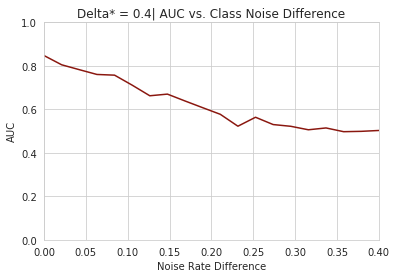

In [13]:
delta_star = .5
delta_star = .4
deltas = [(delta_star-delta, delta_star+delta) for delta in np.linspace(0, .4, 20)]
scores = scores_deltas(deltas, n_runs)
scores_40 = scores

plt.plot(np.linspace(0, .4, 20), scores_40)
plt.xlim(0, .4)
plt.ylim(0, 1)
plt.xlabel("Noise Rate Difference")
plt.ylabel("AUC")
plt.title("Delta* = " +  str(delta_star) + "| AUC vs. Class Noise Difference")

Text(0.5, 1.0, 'Delta* = 0.3 | AUC vs. Class Noise Difference')

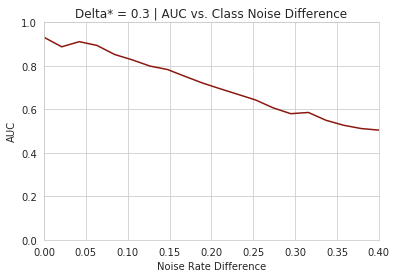

In [14]:
# delta_star = .3
delta_star = .3
deltas = [(delta_star-delta, delta_star+delta) for delta in np.linspace(0, .4, 20)]
scores = scores_deltas(deltas, n_runs)
scores_30 = scores
plt.plot(np.linspace(0, .4, 20), scores)
plt.xlim(0, .4)
plt.ylim(0, 1)
plt.xlabel("Noise Rate Difference")
plt.ylabel("AUC")
plt.title("Delta* = " +  str(delta_star) + " | AUC vs. Class Noise Difference")

Text(0.5, 1.0, 'Delta* = 0.2 | AUC vs. Class Noise Difference')

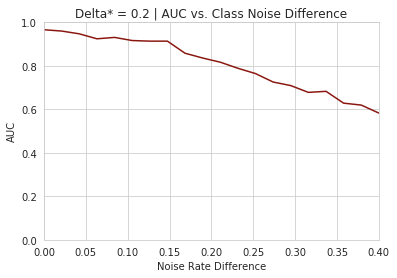

In [16]:
# delta_star = .2
delta_star = .2
deltas = [(delta_star-delta, delta_star+delta) for delta in np.linspace(0, .4, 20)]
scores = scores_deltas(deltas, n_runs)
scores_20 = scores
plt.plot(np.linspace(0, .4, 20), scores_20)
plt.xlim(0, .4)
plt.ylim(0, 1)
plt.xlabel("Noise Rate Difference")
plt.ylabel("AUC")
plt.title("Delta* = " +  str(delta_star) + " | AUC vs. Class Noise Difference")

Text(0.5, 1.0, 'Delta* = 0.1 | AUC vs. Class Noise Difference')

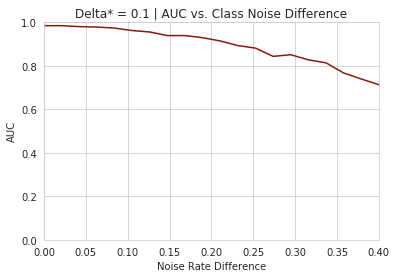

In [17]:
# delta_star = .1
delta_star = .1
deltas = [(delta_star-delta, delta_star+delta) for delta in np.linspace(0, .4, 20)]
scores = scores_deltas(deltas, n_runs)
scores_10 = scores
plt.plot(np.linspace(0, .4, 20), scores_10)
plt.xlim(0, .4)
plt.ylim(0, 1)
plt.xlabel("Noise Rate Difference")
plt.ylabel("AUC")
plt.title("Delta* = " +  str(delta_star) + " | AUC vs. Class Noise Difference")

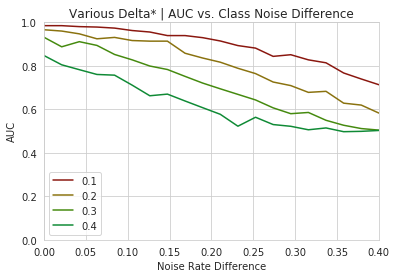

In [23]:
plt.plot(np.linspace(0, .4, 20), scores_10, label="0.1")
plt.plot(np.linspace(0, .4, 20), scores_20, label="0.2")
plt.plot(np.linspace(0, .4, 20), scores_30, label="0.3")
plt.plot(np.linspace(0, .4, 20), scores_40, label="0.4")
plt.xlim(0, .4)
plt.ylim(0, 1)
plt.xlabel("Noise Rate Difference")
plt.ylabel("AUC")
plt.title("Various Delta* | AUC vs. Class Noise Difference")
plt.legend()

## Fixed Total Noise Experiment
Toy Experiment. We fix the "total amount of noise" which is the sum of the label flipping rate for both classes. For instance, set `delta_0 + delta_1 = 0.5`. 
We examine a variety of different `(delta_0, delta_1)` combinations to see which of them results in the highest test accuracy.

[0.7064, 0.7576, 0.7748, 0.7996, 0.8484, 0.8504, 0.8992, 0.9192, 0.9324, 0.9484, 0.9528, 0.9716, 0.9624, 0.9776, 0.9848, 0.986, 0.9912, 0.992, 0.9948, 0.9964]


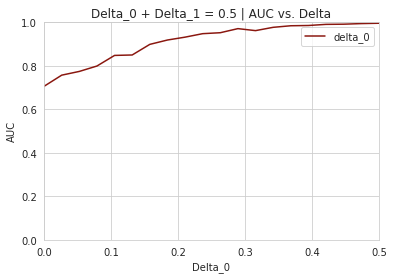

In [43]:
total_noise = 0.5
delta_vals = [(delta_0, total_noise-delta_0) for delta_0 in np.linspace(0, total_noise, 20)]
scores = scores_deltas(delta_vals, n_runs)

fixed_total_noise_scores = scores

print(fixed_total_noise_scores)
delta_0_coords = [delta_0 for (delta_0, delta_1) in delta_vals]
#delta_1_coords = [delta_1 for (delta_0, delta_1) in delta_vals]

plt.plot(delta_0_coords, fixed_total_noise_scores, label='delta_0')
#plt.plot(delta_1_coords, fixed_total_noise_scores, label='delta_1')
plt.ylim(0, 1)
plt.xlim(0, 0.5)
plt.xlabel("Delta_0")
plt.ylabel("AUC")
plt.title("Delta_0 + Delta_1 = 0.5 | AUC vs. Delta")
plt.legend()


In [38]:
# Noise adding protocl
# Hypothesis: # of misclassified examples is related to difference in label error rates
# Generate data
n_runs = 1
delta_0 = .2
delta_1 = .3
train, val, test = get_data(n_examples, n_runs, delta_0, delta_1)
X_train, y_train, y_train_tildes = train
X_val,  y_val = val
X_test, y_test = test

# Identify which class suffers from more noise
lr = LogisticRegression(solver='lbfgs')
lr.fit(X_train, y_train_tildes[0])

y_pred = lr.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
val_accs = cm.diagonal()
noiseless_class = np.argmax(val_accs)
print(val_accs, noiseless_class)

raw_acc = lr.score(X_test, y_test)
print("Raw accuracy on test: ", lr.score(X_test, y_test))

delta_plus_opts = [.05, .1, .15, .2, .25, .3, .35, .4]
delta_plus_accs = []
for delta_plus in delta_plus_opts:
    y_tilde_prime = add_noise_to_class(delta_plus, noiseless_class, y_train_tildes[0])
    lr_new = LogisticRegression(solver='lbfgs')
    lr_new.fit(X_train, y_tilde_prime)
    lr_new_acc = lr_new.score(X_test, y_test)
    delta_plus_accs.append(lr_new_acc)
    print("New accuracy on test: ", lr_new_acc)

[1.         0.85955056] 0
Raw accuracy on test:  0.926
New accuracy on test:  0.9604
New accuracy on test:  0.9824
New accuracy on test:  0.99
New accuracy on test:  0.9956
New accuracy on test:  0.994
New accuracy on test:  0.9864
New accuracy on test:  0.9664
New accuracy on test:  0.9128


#### Notes

This could be used to 
* determine noise levels in datasets where the noise is unknown
* increase accuracy by introducing noise

Things that are necessary
* in what scenarios is this better than noise removal techniques?


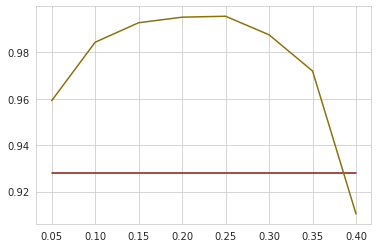

In [10]:
plt.plot(delta_plus_opts, [raw_acc for x in delta_plus_opts]) # red line: baseline accuracy, 
plt.plot(delta_plus_opts, delta_plus_accs) # gold line: accuracy after adding noise